In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import seaborn as sns

# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression 

import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare

In [2]:
df = acquire.acquire_zillow()
df = prepare.clean_zillow(df)
df = prepare.focused_zillow(df)
train, validate, test = prepare.split_focused_zillow(df)

In [3]:
X_train = train.drop(columns = ['appraised_value'])
y_train = train[['appraised_value']]

X_validate = validate.drop(columns=['appraised_value'])
y_validate = validate[['appraised_value']]

X_test = test.drop(columns=['appraised_value'])
y_test = test[['appraised_value']]

#x is feature
# y is traget variable

In [4]:
train.head()

,square_feet,bedrooms,bathrooms,appraised_value
31538,1050.0,2.0,1.0,292000.0
5911,715.0,1.0,1.0,97093.0
20091,2097.0,2.0,2.0,80091.0
36157,1216.0,3.0,1.0,34746.0
1799,1523.0,3.0,3.0,177000.0


In [5]:
y_train

,appraised_value
31538,292000.0
5911,97093.0
20091,80091.0
36157,34746.0
1799,177000.0
...,...
9333,533508.0
33620,179483.0
10204,44689.0
37283,443829.0


# Baseline

In [6]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
    # turn it into a single pandas dataframe
y_validate = pd.DataFrame(y_validate)
    # wrap them as dataframes

# 1. Predict appraised_value_pred_mean
    # 2 different aselines of mean and medium
appraised_value_pred_mean = y_train['appraised_value'].mean()
y_train['appraised_value_pred_mean'] = appraised_value_pred_mean
y_validate['appraised_value_pred_mean'] = appraised_value_pred_mean

# 2. compute appraised_value_pred_median
    # same process as mean (above)
appraised_value_pred_median = y_train['appraised_value'].median()
y_train['appraised_value_pred_median'] = appraised_value_pred_median
y_validate['appraised_value_pred_median'] = appraised_value_pred_median

# 3. RMSE of appraised_value_pred_mean
rmse_train_mean = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_mean)**(1/2)
    # stick with root mean square error
        # not your only option but that is what we will be using here
            # just because it is eaiest to us and explain
    # remember when you call you it will be your y_true and y_pred
rmse_validate_mean = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_mean)**(1/2)
    # do the same thing for the validate set as done above for the train set
    
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print(' ')
# 4. RMSE of appraised_value_pred_median
rmse_train_medium = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_median)**(1/2)

rmse_validate_medium = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_medium, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_medium, 2))

# median comes out a little higher than mean 
    # but a little lower than our validation set

RMSE using Mean
Train/In-Sample:  227271.86 
Validate/Out-of-Sample:  228115.48
 
RMSE using Median
Train/In-Sample:  229967.62 
Validate/Out-of-Sample:  231044.18


# Linear Regression Model (OLS)
1. Fit the model using X_train_scaled and the labels from y_train.

2. Predict final grade for students in training sample using our model (lm).

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation.

5. Compare RMSE train vs. validation. Overfitting?

In [7]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.appraised_value)
    # just call y_train.actual_target

# predict train
y_train['appraised_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_lm)**(1/2)

# predict validate
y_validate['appraised_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_lm)**(1/2)
    # make sure you are using x_validate an not x_train

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

RMSE for OLS using LinearRegression
Training/In-Sample:  201813.73681808176 
Validation/Out-of-Sample:  202696.95094364075


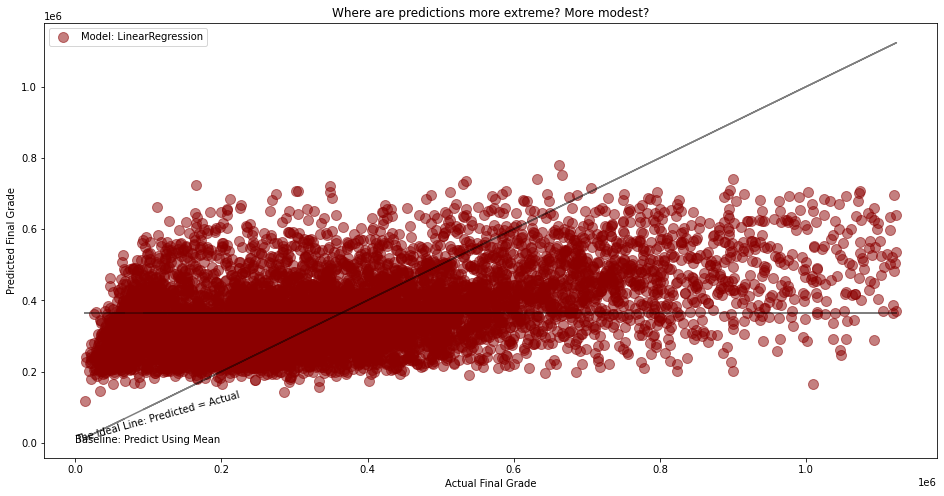

In [8]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="darkred", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# LassoLars
1. Fit the model using X_train_scaled and the labels from y_train.

2. Predict final grade for students in training sample using our model (lars).

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation.

5. Compare RMSE train vs. validation. Overfitting?

In [9]:
# create the model object
lars = LassoLars(alpha=1.0)
    # what alpha is in this case
        # kidn of that regualizer that make lasso a little bit different
        # can go from 0 to infinity
            # it will eventually stop changing the efficivicy of you model 
                # depenind on th enumber of features being fed in
            # if alpha = 0 it is the same thing as a los model

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.appraised_value)
    # fit the thing

# predict train
y_train['appraised_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_lars)**1/2

# predict validate
y_validate['appraised_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_lars)**1/2

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  20364445665.7664 
Validation/Out-of-Sample:  20542786732.111324


Text(0.5, 1.0, 'Where are predictions more extreme? More modest?')

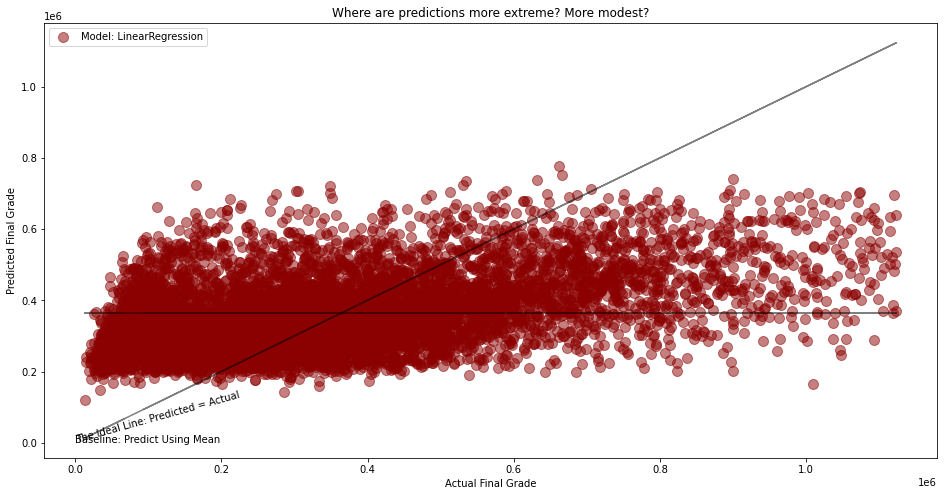

In [10]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 
            alpha=.5, color="darkred", s=100, label="Model: LinearRegression")

plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")

# TweedieRegressor (GLM)
1. Fit the model using X_train_scaled and the labels from y_train.

2. Predict final grade for students in training sample using our model (glm).

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation.

5. Compare RMSE train vs. validation. Overfitting?

In [11]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['appraised_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_glm)**1/2

# predict validate
y_validate['appraised_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_glm)**1/2

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train_glm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  25826248340.195675 
Validation/Out-of-Sample:  26018336332.93955


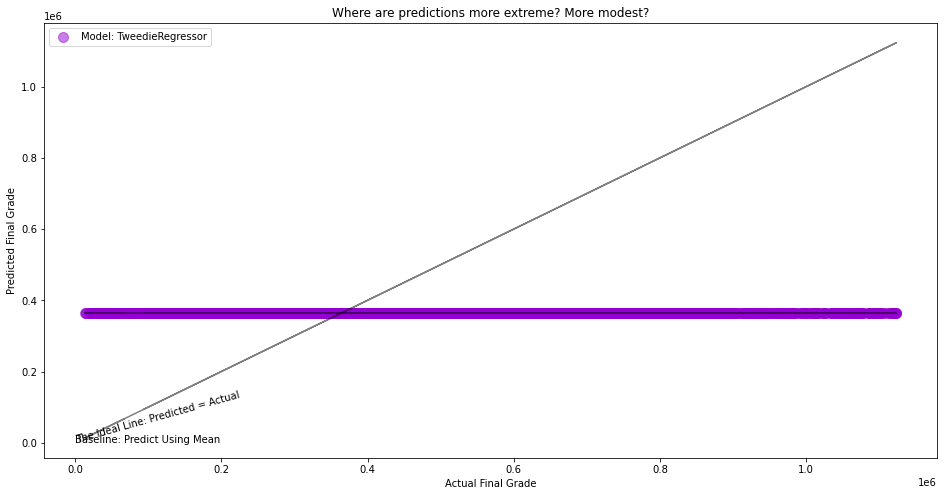

In [12]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="darkviolet", s=100, label="Model: TweedieRegressor")

plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Polynomial Regression
Using `sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()`

1. Create the new features, based on value indicated for degree for train, validate & test.

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

**PolynomialFeatures**


In [13]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
    # dont call fit transform just call transform
        # we only fit train not validate
X_test_degree2 = pf.transform(X_test)

# Linear Regression

In [14]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.appraised_value)

# predict train
y_train['appraised_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.appraised_value, y_train.appraised_value_pred_lm2)**1/2

# predict validate
y_validate['appraised_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.appraised_value, y_validate.appraised_value_pred_lm2)**1/2

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_lm2, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm2)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20298379492.33372 
Validation/Out-of-Sample:  20476129727.74332


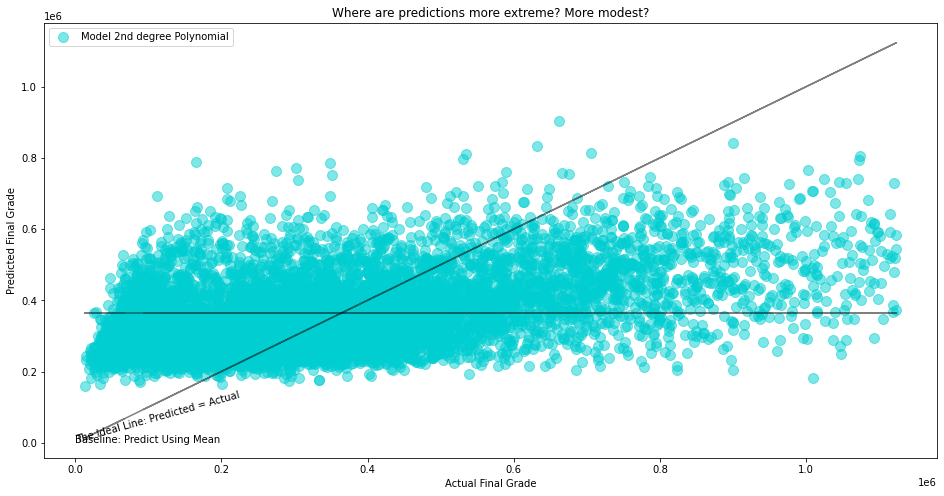

In [15]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="darkturquoise", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

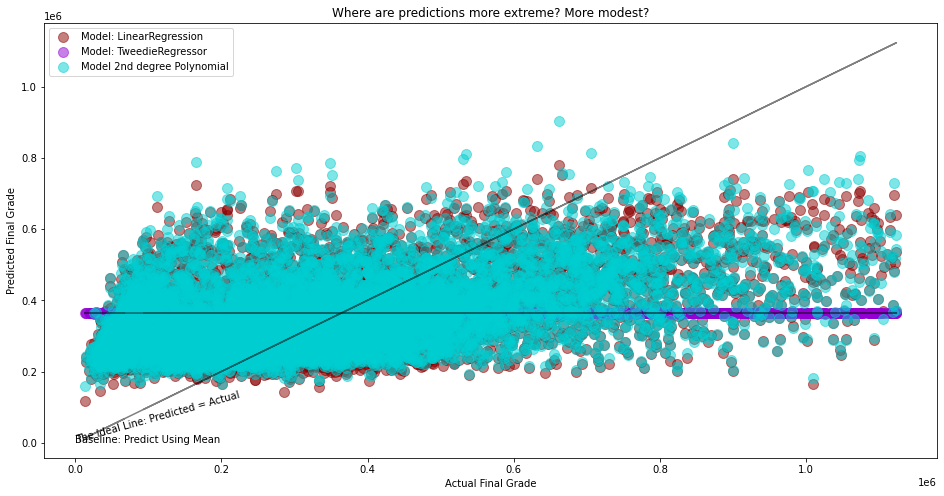

In [16]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="darkred", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="darkviolet", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="darkturquoise", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Plotting Actual vs. Predictive

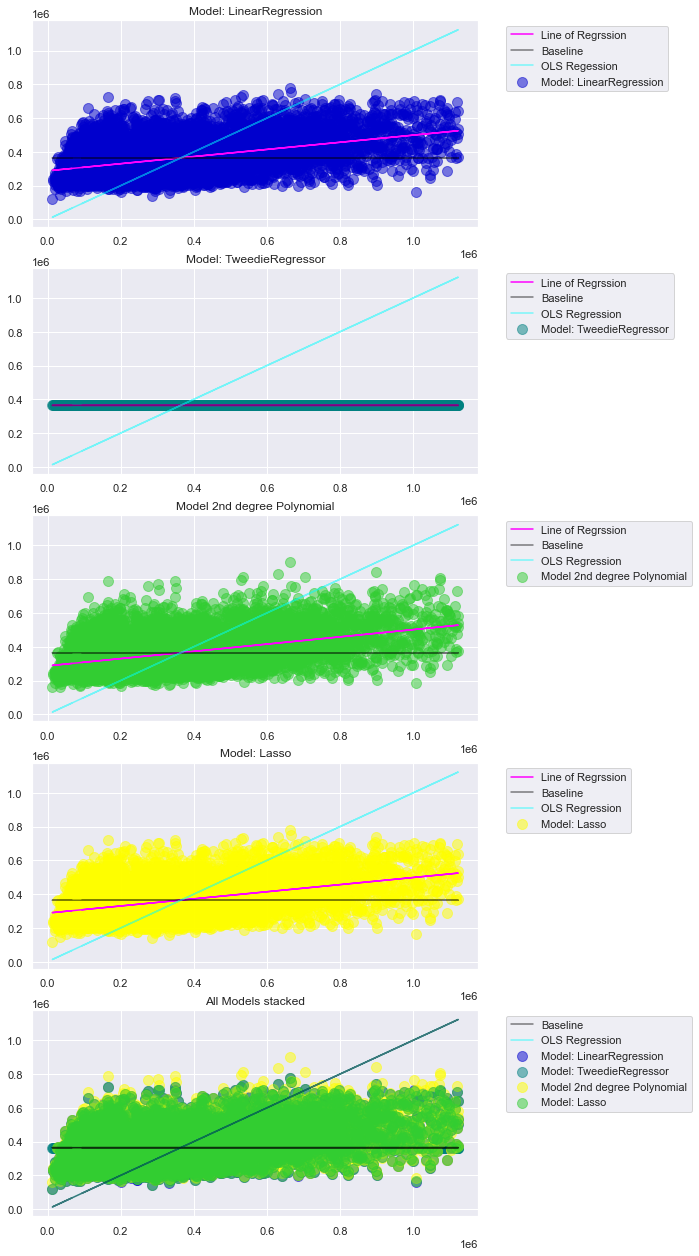

In [17]:
plt.subplots(5, 1, figsize=(8,22), sharey=True)
sns.set(style="darkgrid")

plt.subplot(5,1,1)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 1)
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='OLS Regession')
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,2)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 1) 
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, color='fuchsia', label='Line of Regrssion')
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model: TweedieRegressor')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,3)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="limegreen", s=100, label="Model 2nd degree Polynomial")

m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 1) 
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, color='fuchsia', label='Line of Regrssion')

plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model 2nd degree Polynomial')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,4)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso")

m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 1) 
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, color='fuchsia', label='Line of Regrssion')

plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='OLS Regression')
plt.title('Model: Lasso')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,5)
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='Baseline')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='OLS Regression')
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 
            alpha=.5, color="limegreen", s=100, label="Model: Lasso")

plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.title('All Models stacked')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


# Residual Plots: Plotting the Errors in Predictions

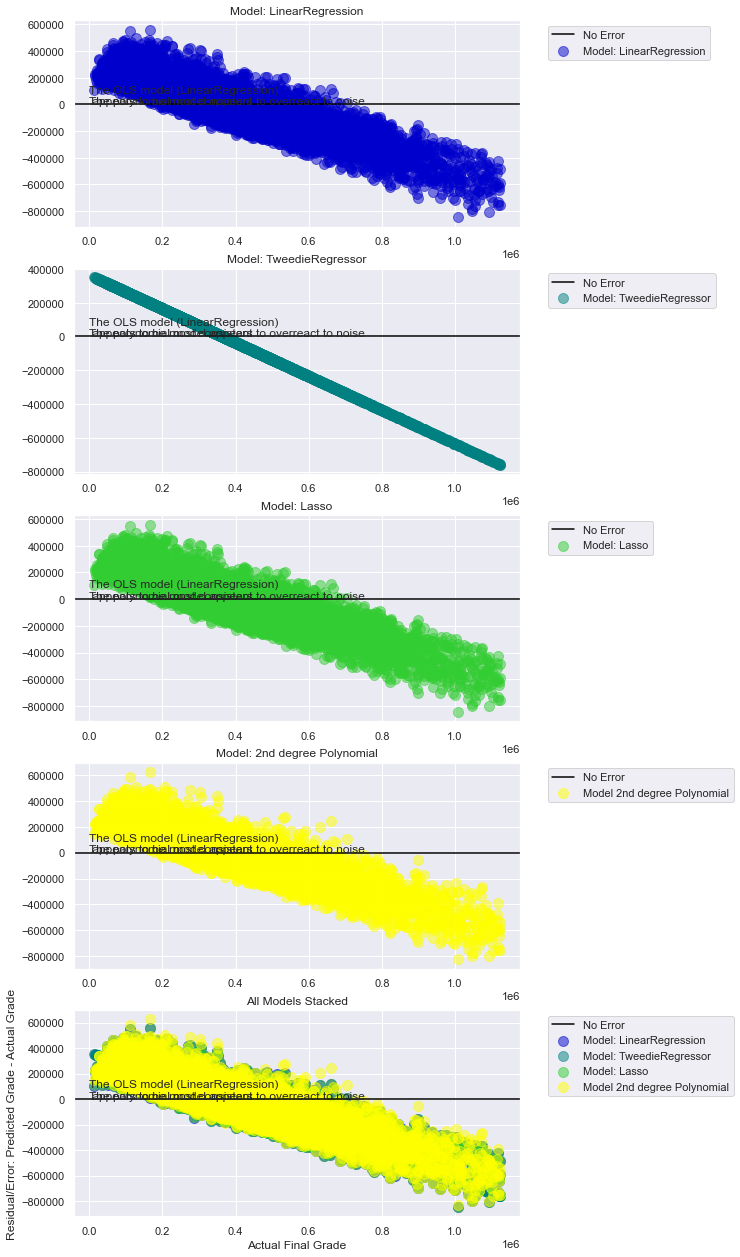

In [18]:
plt.subplots(5, 1, figsize=(8,22), sharey=True)
sns.set(style="darkgrid")

plt.subplot(5,1,1)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm-y_validate.appraised_value, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.axhline(label="No Error", color='black')
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,2)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm-y_validate.appraised_value, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.axhline(label="No Error", color='black')
plt.title('Model: TweedieRegressor')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,3)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars-y_validate.appraised_value, 
            alpha=.5, color="limegreen", s=100, label="Model: Lasso")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.axhline(label="No Error", color='black')
plt.title('Model: Lasso')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,4)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2-y_validate.appraised_value, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.axhline(label="No Error", color='black')
plt.title('Model: 2nd degree Polynomial')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


plt.subplot(5,1,5)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm-y_validate.appraised_value, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm-y_validate.appraised_value, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars-y_validate.appraised_value, 
            alpha=.5, color="limegreen", s=100, label="Model: Lasso")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2-y_validate.appraised_value, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.axhline(label="No Error", color='black')
plt.title("All Models Stacked")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Histogram of Appraised Values

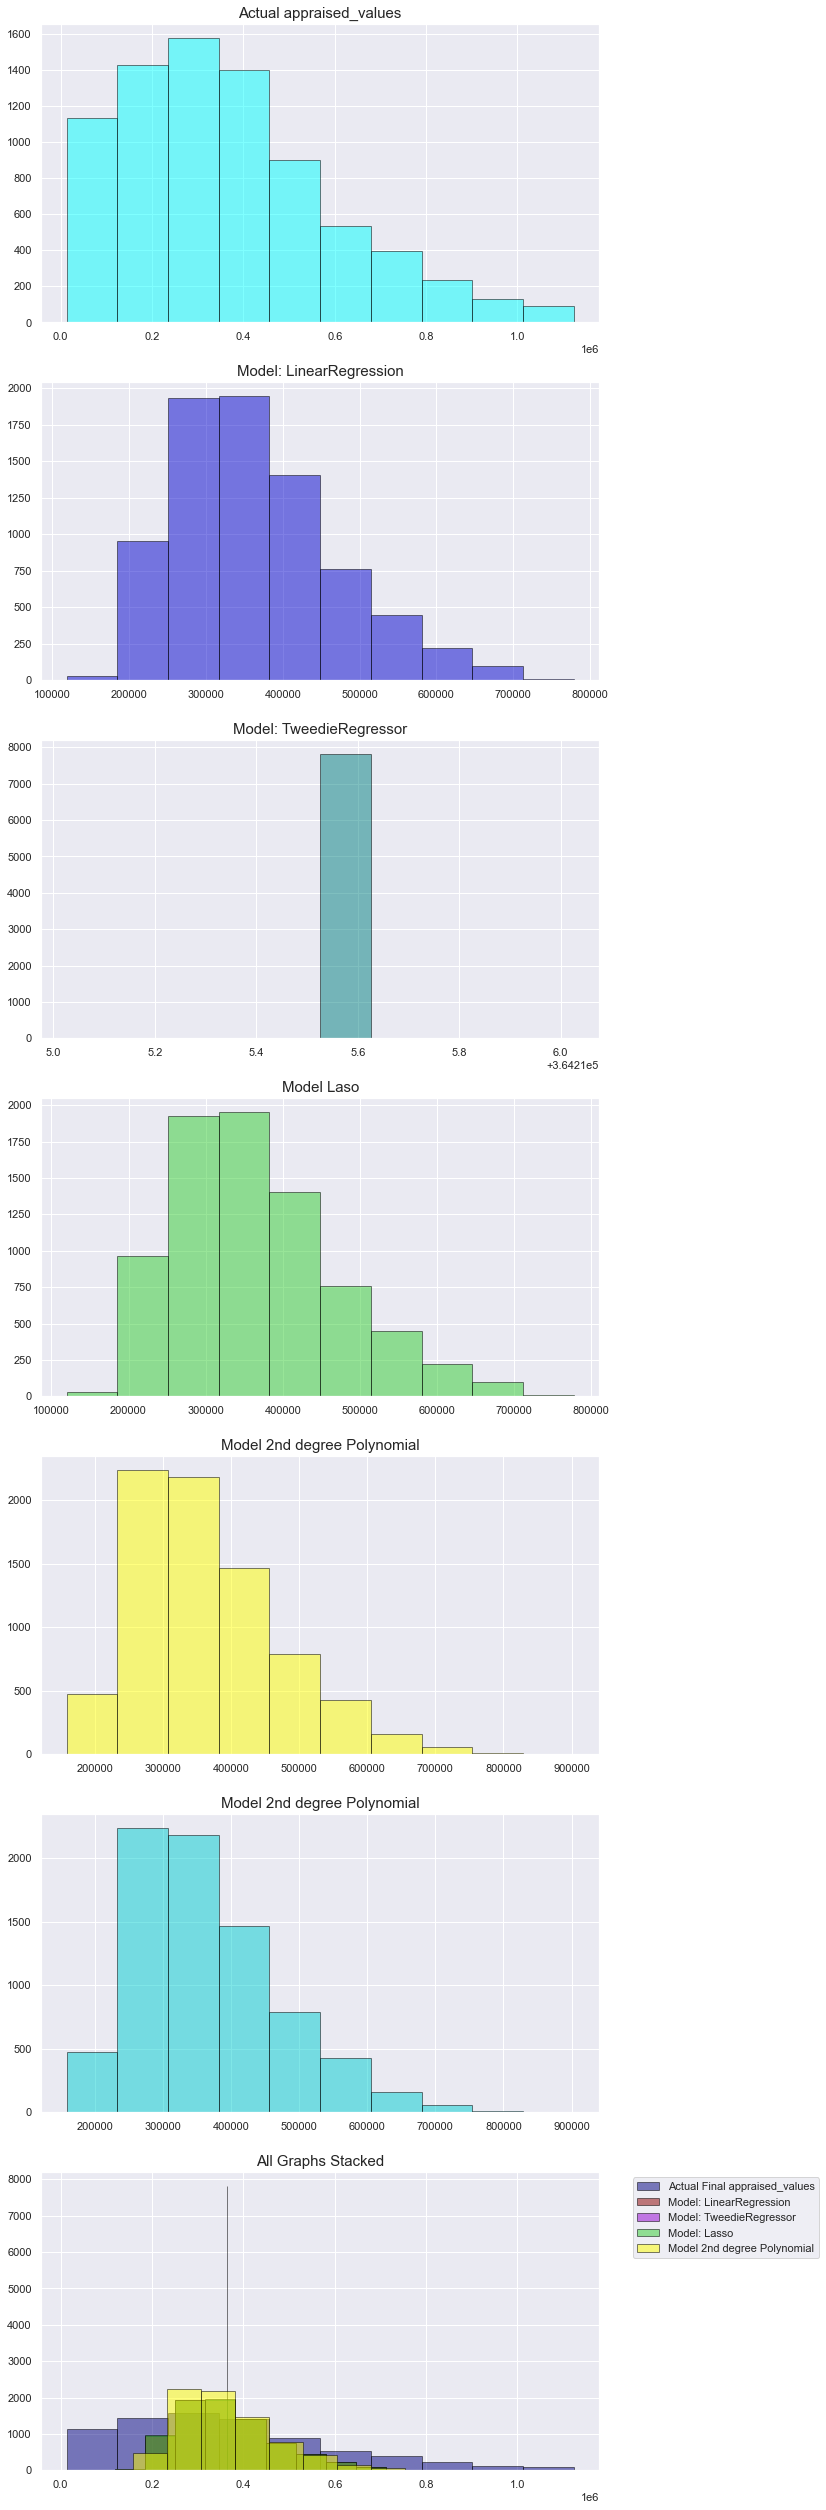

In [19]:
plt.subplots(2, 5, figsize=(10,45), sharey=True)
sns.set(style="darkgrid")
plt.title("Comparing the Distribution of appraised_values to Distributions of Predicted appraised_values for the Top Models")
plt.xlabel("appraised_value", size = 15)
plt.ylabel("appraised_value Count", size = 15)

plt.subplot(7,1,1)
plt.hist(y_validate.appraised_value, color='cyan', alpha=.5,  ec='black')
plt.title('Actual appraised_values', size=15)

plt.subplot(7,1,2)
plt.hist(y_validate.appraised_value_pred_lm, color='mediumblue', alpha=.5,  ec='black')
plt.title('Model: LinearRegression', size=15)

plt.subplot(7,1,3)
plt.hist(y_validate.appraised_value_pred_glm, color='teal', alpha=.5,  ec='black')
plt.title('Model: TweedieRegressor', size=15)

plt.subplot(7,1,4)
plt.hist(y_validate.appraised_value_pred_lars, color='limegreen', alpha=.5, ec='black')
plt.title('Model Laso', size=15)  

plt.subplot(7,1,5)
plt.hist(y_validate.appraised_value_pred_lm2, color='yellow', alpha=.5, ec='black')
plt.title('Model 2nd degree Polynomial', size=15)
    
plt.subplot(7,1,6)
plt.hist(y_validate.appraised_value_pred_lm2, color='darkturquoise', alpha=.5, ec='black')
plt.title('Model 2nd degree Polynomial', size=15)

plt.subplot(7,1,7)
plt.hist(y_validate.appraised_value, color='navy', alpha=.5, label="Actual Final appraised_values", ec='black')
plt.hist(y_validate.appraised_value_pred_lm, color='darkred', alpha=.5, label="Model: LinearRegression", ec='black')
plt.hist(y_validate.appraised_value_pred_glm, color='darkviolet', alpha=.5, label="Model: TweedieRegressor", ec='black')
plt.hist(y_validate.appraised_value_pred_lars, color='limegreen', alpha=.5, ec='black', label="Model: Lasso")
plt.hist(y_validate.appraised_value_pred_lm2, color='yellow', alpha=.5, label="Model 2nd degree Polynomial", ec='black')
plt.title("All Graphs Stacked", size=15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

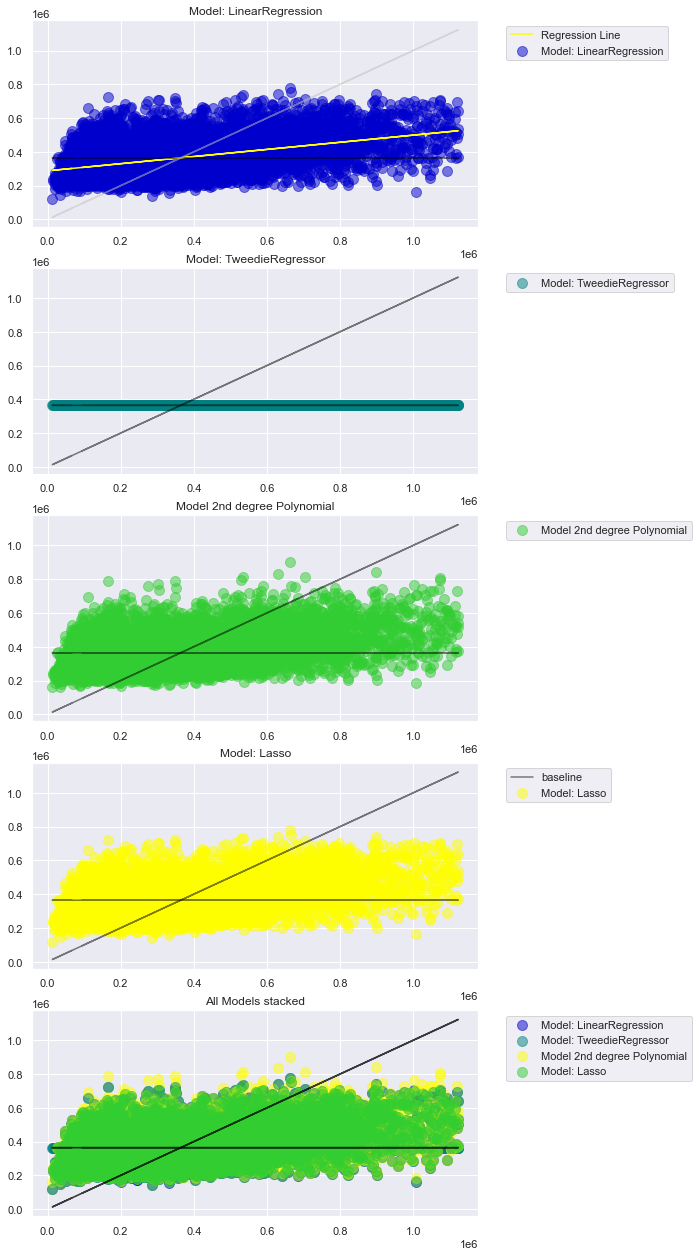

In [20]:
plt.subplots(5, 1, figsize=(8,22), sharey=True)
sns.set(style="darkgrid")

plt.subplot(5,1,1)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")

m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 1)
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, label="Regression Line", color='yellow')

plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="silver", label='_nolegend_')
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,2)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.title('Model: TweedieRegressor')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,3)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="limegreen", s=100, label="Model 2nd degree Polynomial")
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.title('Model 2nd degree Polynomial')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,4)
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso")
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='baseline')
plt.title('Model: Lasso')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,5)
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_glm, 
            alpha=.5, color="teal", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lars, 
            alpha=.5, color="limegreen", s=100, label="Model: Lasso")

plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="black", label='_nolegend_')
plt.title('All Models stacked')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [21]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print("--------------------------------------------------------------")
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_medium, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_medium, 2))
print("--------------------------------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)
print("--------------------------------------------------------------")
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)
print("--------------------------------------------------------------")
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train_glm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)
print("--------------------------------------------------------------")
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_lm2, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm2)

RMSE using Mean
Train/In-Sample:  227271.86 
Validate/Out-of-Sample:  228115.48
--------------------------------------------------------------
RMSE using Median
Train/In-Sample:  229967.62 
Validate/Out-of-Sample:  231044.18
--------------------------------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  201813.73681808176 
Validation/Out-of-Sample:  202696.95094364075
--------------------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  20364445665.7664 
Validation/Out-of-Sample:  20542786732.111324
--------------------------------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  25826248340.195675 
Validation/Out-of-Sample:  26018336332.93955
--------------------------------------------------------------
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20298379492.33372 
Validation/Out-of-Sample:  20476129727.74332


# Model Selected: RMSE for OLS using LinearRegression

In [22]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print("--------------------------------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lm)

RMSE using Mean
Train/In-Sample:  227271.86 
Validate/Out-of-Sample:  228115.48
--------------------------------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  201813.73681808176 
Validation/Out-of-Sample:  202696.95094364075


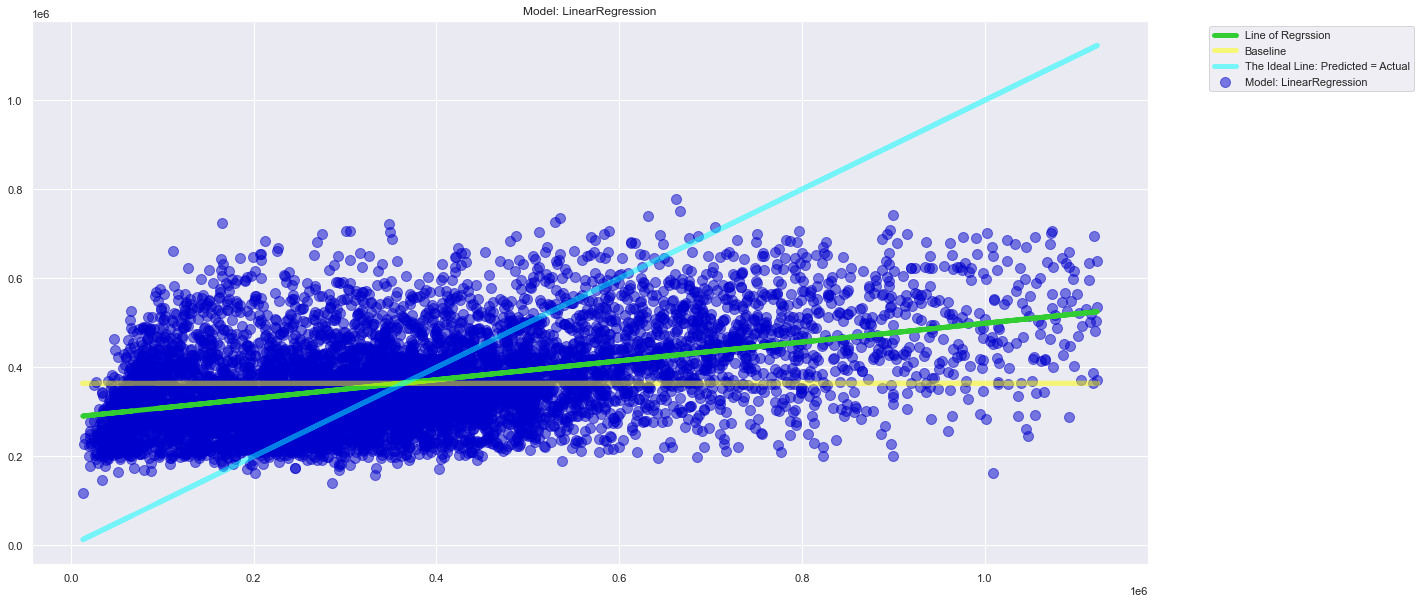

In [23]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
m, b = np.polyfit(y_validate.appraised_value, y_validate.appraised_value_pred_lm, 1)
plt.plot(y_validate.appraised_value, m*y_validate.appraised_value+b, color='limegreen', label='Line of Regrssion', linewidth=5)
plt.plot(y_validate.appraised_value, y_validate.appraised_value_pred_mean, alpha=.5, color="yellow", label='Baseline', linewidth=5)
plt.plot(y_validate.appraised_value, y_validate.appraised_value, alpha=.5, color="cyan", label='The Ideal Line: Predicted = Actual', linewidth=5)
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

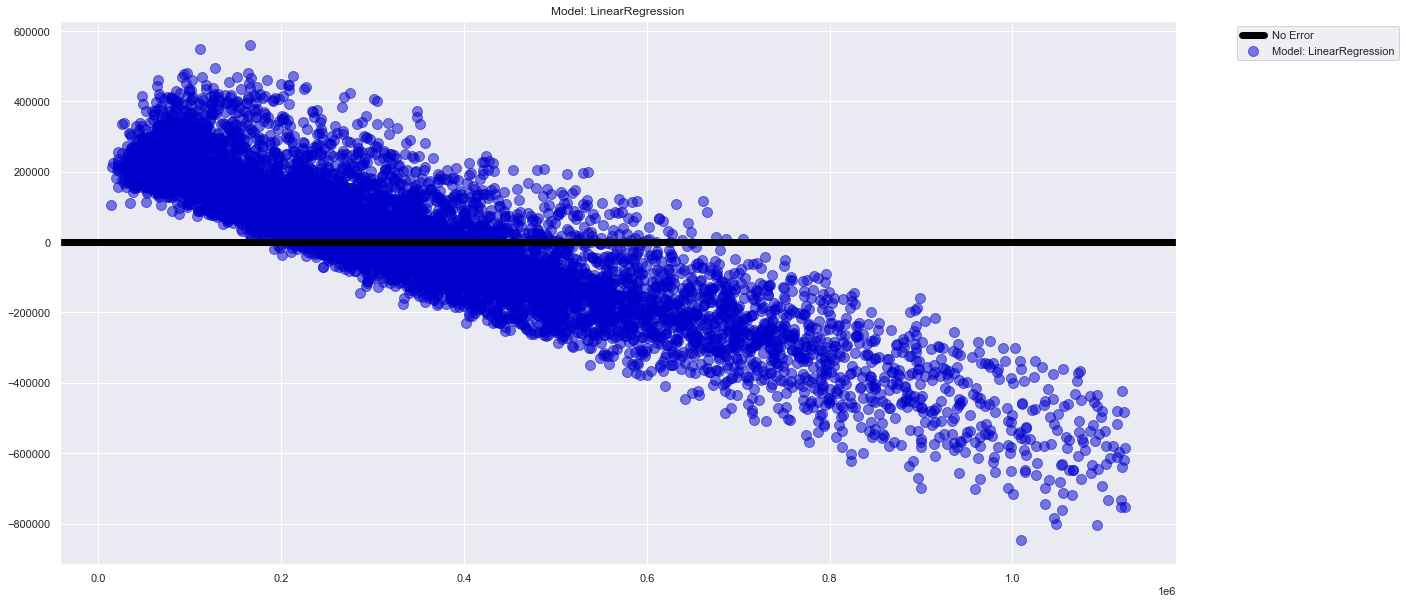

In [24]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")

plt.scatter(y_validate.appraised_value, y_validate.appraised_value_pred_lm-y_validate.appraised_value, 
            alpha=.5, color="mediumblue", s=100, label="Model: LinearRegression")
plt.axhline(label="No Error", color='black', linewidth=7)
plt.title('Model: LinearRegression')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

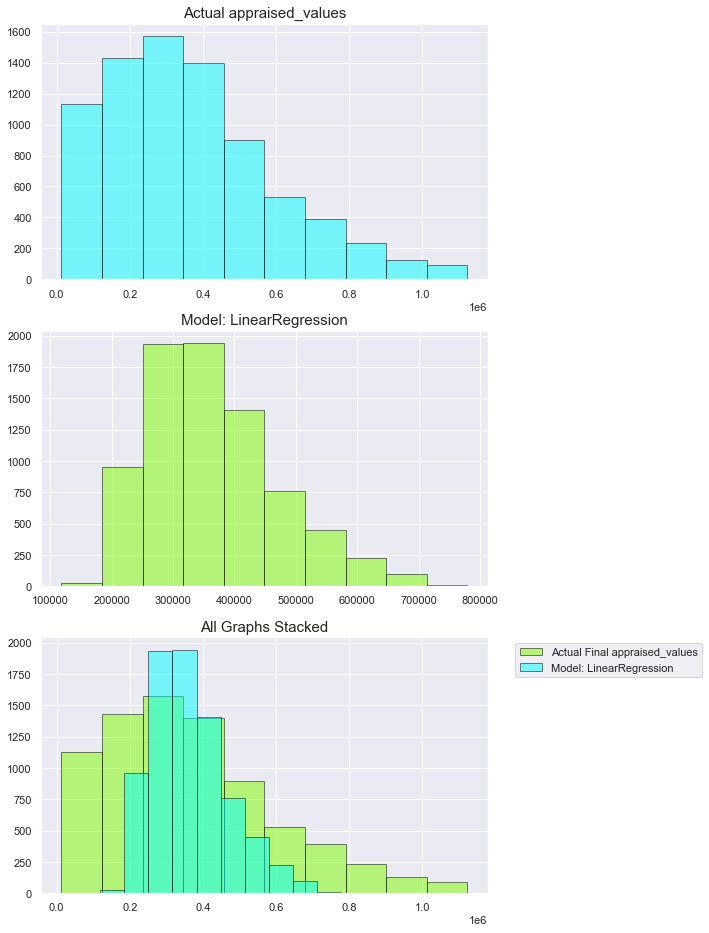

In [32]:
plt.subplots(3, 5, figsize=(8,16), sharey=True)
sns.set(style="darkgrid")
plt.title("Comparing the Distribution of appraised_values to Distributions of Predicted appraised_values Linear Regression Models")
plt.xlabel("appraised_value", size = 15)
plt.ylabel("appraised_value Count", size = 15)

plt.subplot(3,1,1)
plt.hist(y_validate.appraised_value, color='cyan', alpha=.5,  ec='black')
plt.title('Actual appraised_values', size=15)

plt.subplot(3,1,2)
plt.hist(y_validate.appraised_value_pred_lm, color='lawngreen', alpha=.5,  ec='black')
plt.title('Model: LinearRegression', size=15)

plt.subplot(3,1,3)
plt.hist(y_validate.appraised_value, color='lawngreen', alpha=.5, label="Actual Final appraised_values", ec='black')
plt.hist(y_validate.appraised_value_pred_lm, color='cyan', alpha=.5, label="Model: LinearRegression", ec='black')
plt.title("All Graphs Stacked", size=15)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')